In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import yaml  # If not installed: pip install pyyaml

# Set up algorithm colors
colors = {
    "DQN": 'darkorange',
    "PPO": 'forestgreen',
    "CMA": 'cyan',
    "ODT": 'blueviolet'
}

# Helper functions
def load_config_file(filepath):
    with open(filepath, 'r') as f:
        return yaml.safe_load(f)

def read_csv_data(filepath, columns):
    return pd.read_csv(filepath, usecols=columns)


In [9]:
# Define experiment range and chunk size
starting_exp = 5108
ending_exp = 5144
chunk_size = 3

all_experiments = list(range(starting_exp, ending_exp + 1))
experiment_chunks = [all_experiments[i:i + chunk_size] for i in range(0, len(all_experiments), chunk_size)]
save_processed_data = True
file_path_for_processed_data = './processed_data'

for chunk in experiment_chunks:
    exp_agent_data = []
    
    for exp_num in chunk:
        config_fname = f'./Exp_{exp_num}/config.yaml'
        c = load_config_file(config_fname)
        nn_c = c['nn_hyperparameters']
        federated_c = c['federated_learning_settings']
        algo_c = c['algorithm_settings']
        env_c = c['environment_settings']
        cma_c = c['cma_parameters']
    
        seed = env_c['seed']
        algorithm_dm = algo_c['algorithm']

        def load_from_json_with_error_handling(filepath, columns_specific):
            try:
                return read_csv_data(filepath, columns=columns_specific)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
                return None
    
        path_list = [
            f"/storage_1/epigou_storage/Exp_{exp_num}",
            f"/mnt/storage_1/merl/metrics/Exp_{exp_num}",
            f"../metrics/Exp_{exp_num}"
        ]
    
        d_base = next((p for p in path_list if os.path.exists(p)), None)
        if d_base is None:
            print(f"Data folder not found for experiment {exp_num}; skipping.")
            continue

        base_path = f"{d_base}/train/metrics"
        print(f'Loading {base_path}_agent_metrics.csv for experiment {exp_num}')
        agent_data = load_from_json_with_error_handling(
            f'{base_path}_agent_metrics.csv',
            ['episode', 'timestep', 'done', 'zone', 'aggregation', 'agent_index', 'reward']
        )
        if agent_data is None:
            continue

        agent_data['seed'] = seed
        agent_data['exp_num'] = exp_num
        agent_data['algorithm'] = algorithm_dm
        agent_data['season'] = env_c['season']
        agent_data['num_aggs'] = federated_c['aggregation_count']
        agent_data['eps_per_agg'] = (
            cma_c['max_generations'] if algorithm_dm == 'CMA' else nn_c['num_episodes']
        )

        exp_agent_data.append(agent_data)

    if len(exp_agent_data) == 0:
        continue

    df_agent = pd.concat(exp_agent_data, ignore_index=True)

    cumulative_agent_df = (
        df_agent
        .groupby(
            ['episode', 'zone', 'aggregation', 'agent_index', 'seed', 'exp_num', 'algorithm', 'season', 'num_aggs', 'eps_per_agg']
        )['reward']
        .sum()
        .reset_index()
    )
    cumulative_agent_df.rename(columns={'reward': 'cumulative_reward'}, inplace=True)
    cumulative_agent_df['episode'] = (
        cumulative_agent_df['aggregation'] * cumulative_agent_df['eps_per_agg'] + cumulative_agent_df['episode']
    )

    cumulative_avg_reward_by_algorithm = (
        cumulative_agent_df
        .groupby(['episode', 'algorithm', 'seed', 'num_aggs', 'season', 'eps_per_agg', 'exp_num'])['cumulative_reward']
        .mean()
        .reset_index()
    )

    cumulative_avg_reward_by_algorithm = cumulative_avg_reward_by_algorithm.sort_values(
        ['season', 'algorithm', 'seed', 'num_aggs', 'episode']
    )
    cumulative_avg_reward_by_algorithm['cumulative_reward'] = (
        cumulative_avg_reward_by_algorithm
        .groupby(['algorithm', 'seed', 'num_aggs', 'season'])['cumulative_reward']
        .transform(lambda x: x.expanding().mean())
    )

    if save_processed_data:
        chunk_folder = os.path.join(file_path_for_processed_data, f"{chunk[0]}_{chunk[-1]}")
        os.makedirs(chunk_folder, exist_ok=True)
        csv_path = os.path.join(chunk_folder, f"{chunk[0]}_{chunk[-1]}.csv")
        cumulative_avg_reward_by_algorithm.to_csv(csv_path, index=False)
        print(f"Data successfully saved to {csv_path}")


Loading /storage_1/epigou_storage/Exp_5108/train/metrics_agent_metrics.csv for experiment 5108
Loading /storage_1/epigou_storage/Exp_5109/train/metrics_agent_metrics.csv for experiment 5109
Loading /storage_1/epigou_storage/Exp_5110/train/metrics_agent_metrics.csv for experiment 5110
Data successfully saved to ./processed_data/5108_5110/5108_5110.csv
Loading /storage_1/epigou_storage/Exp_5111/train/metrics_agent_metrics.csv for experiment 5111
Loading /storage_1/epigou_storage/Exp_5112/train/metrics_agent_metrics.csv for experiment 5112
Loading /storage_1/epigou_storage/Exp_5113/train/metrics_agent_metrics.csv for experiment 5113
Data successfully saved to ./processed_data/5111_5113/5111_5113.csv
Loading /storage_1/epigou_storage/Exp_5114/train/metrics_agent_metrics.csv for experiment 5114
Loading /storage_1/epigou_storage/Exp_5115/train/metrics_agent_metrics.csv for experiment 5115
Loading /storage_1/epigou_storage/Exp_5116/train/metrics_agent_metrics.csv for experiment 5116
Data succ

FileNotFoundError: [Errno 2] No such file or directory: '/storage_1/epigou_storage/Exp_5144/train/metrics_agent_metrics.csv'

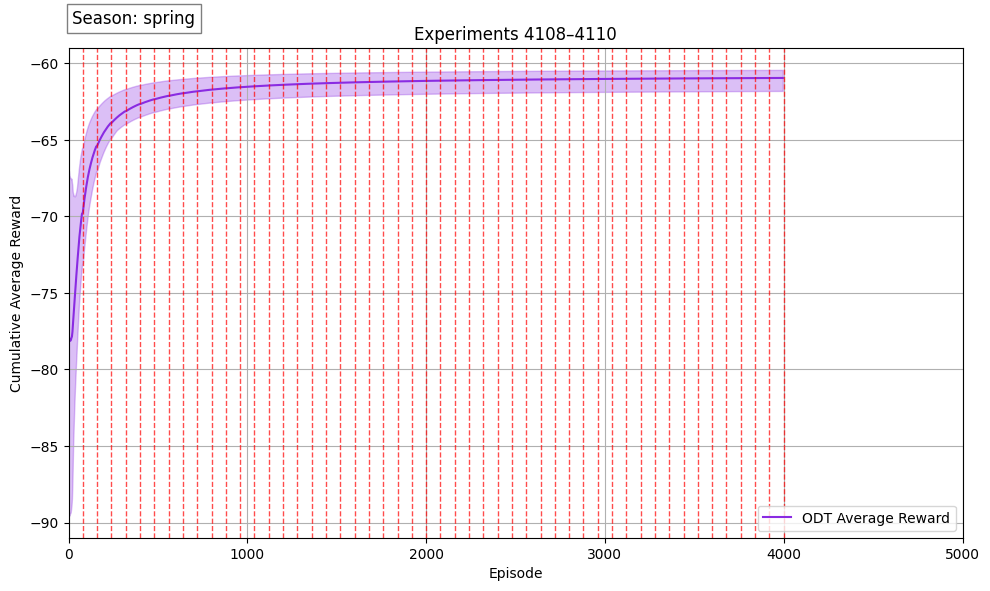

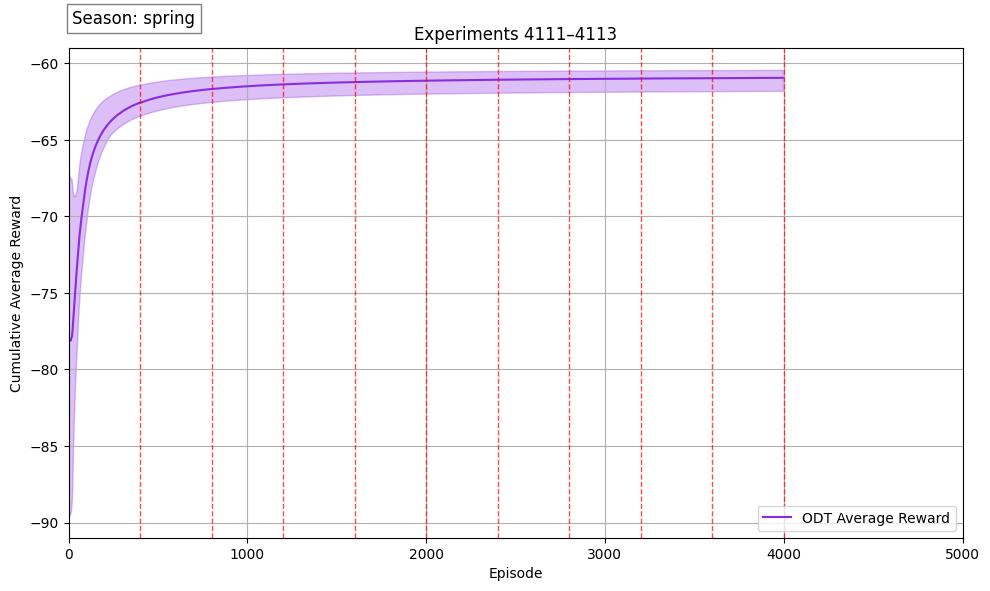

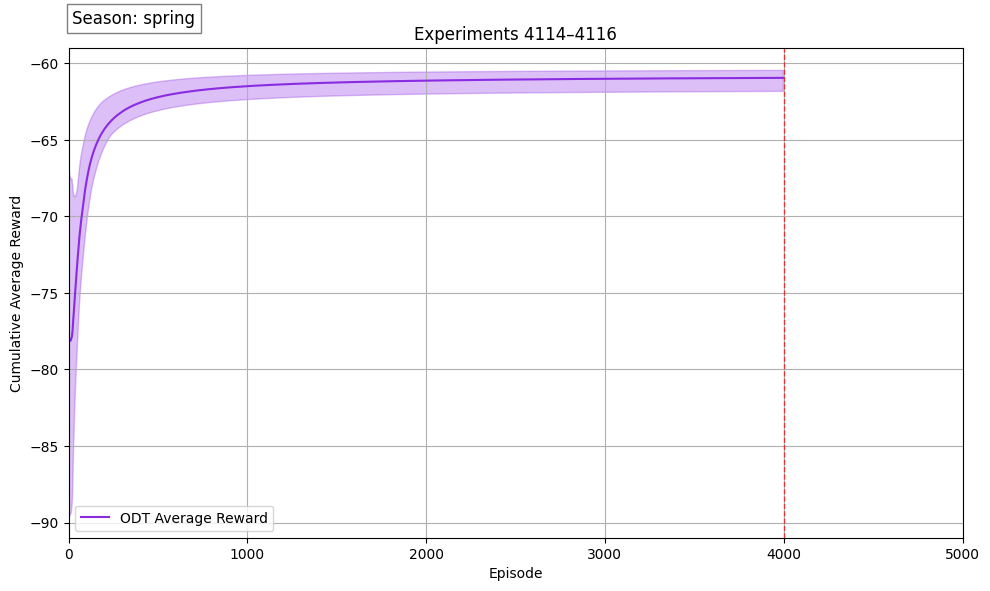

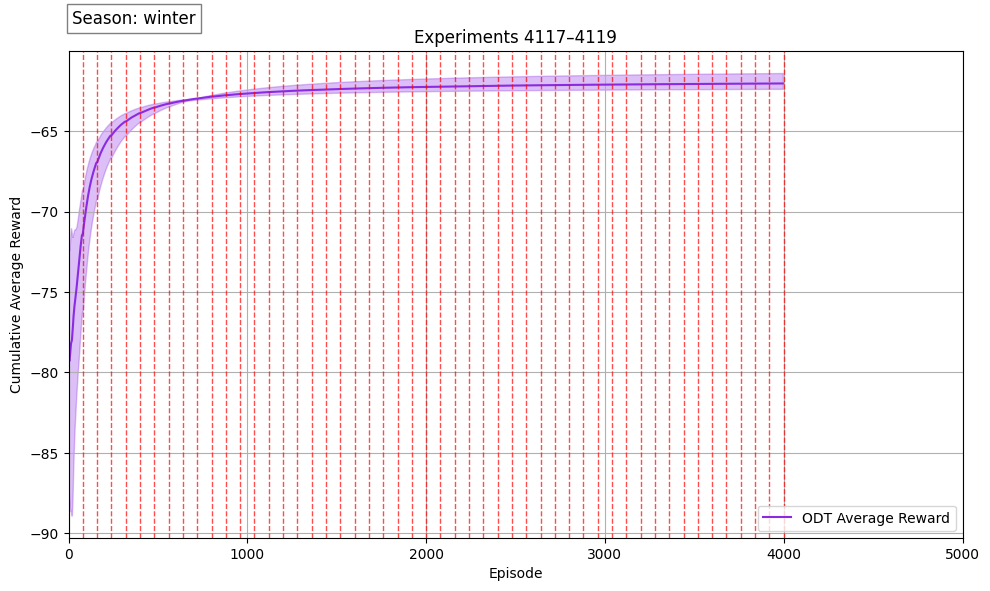

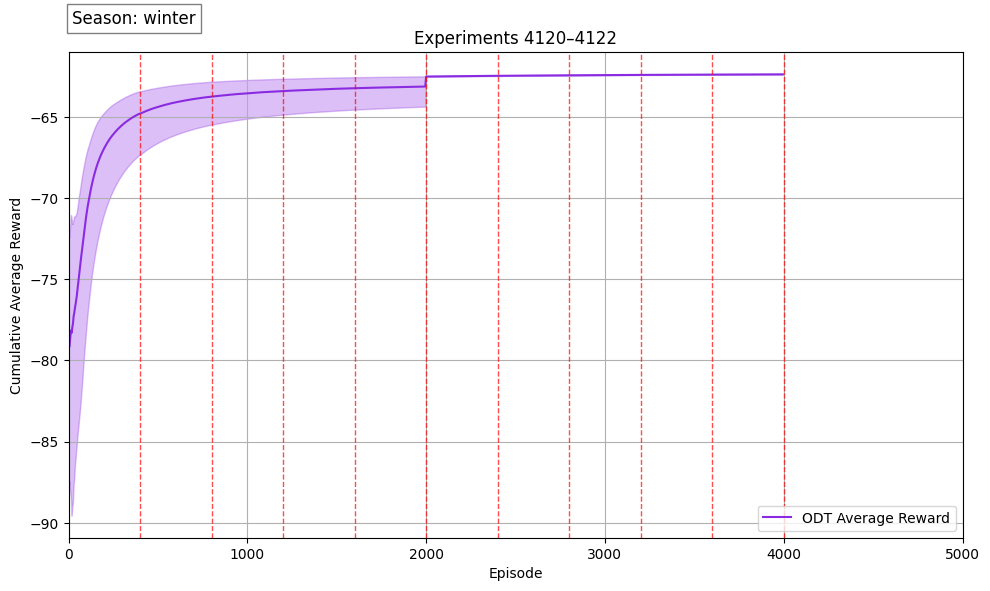

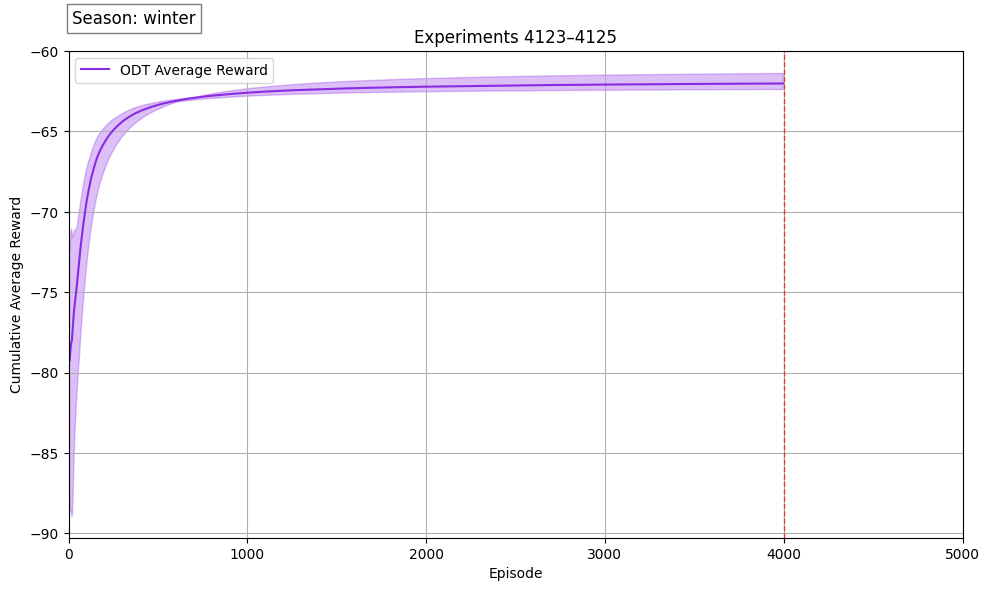

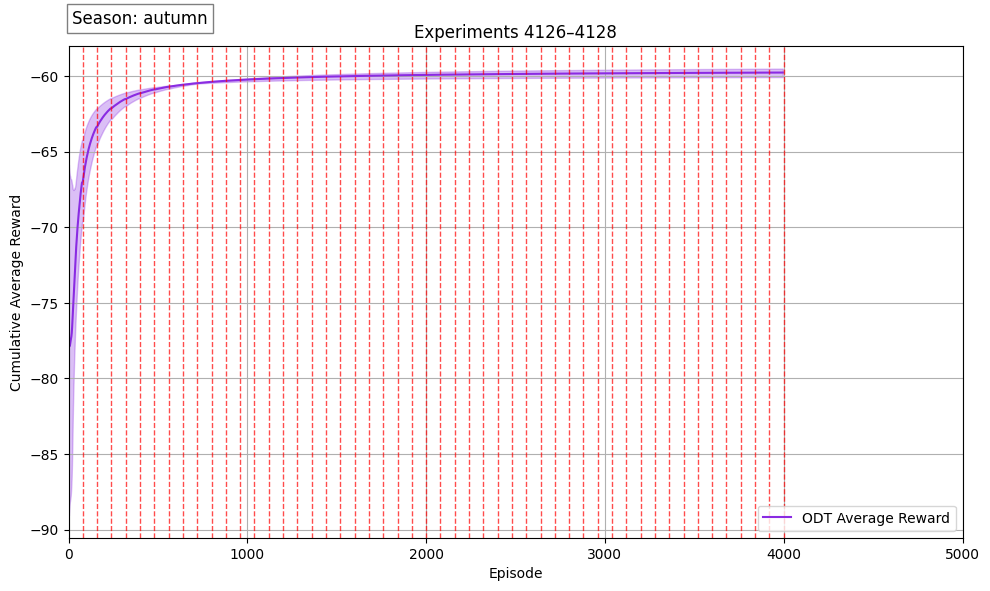

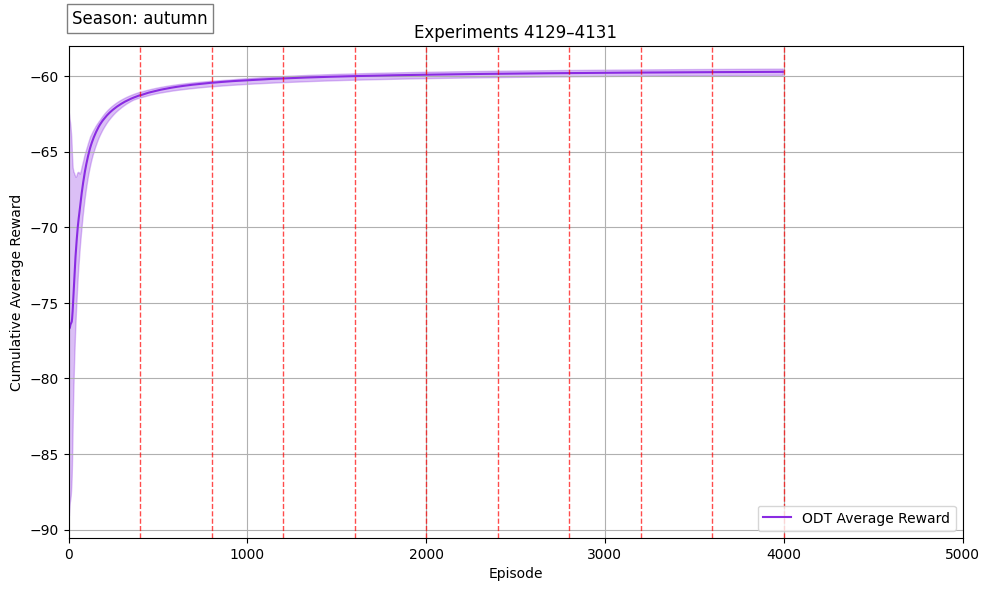

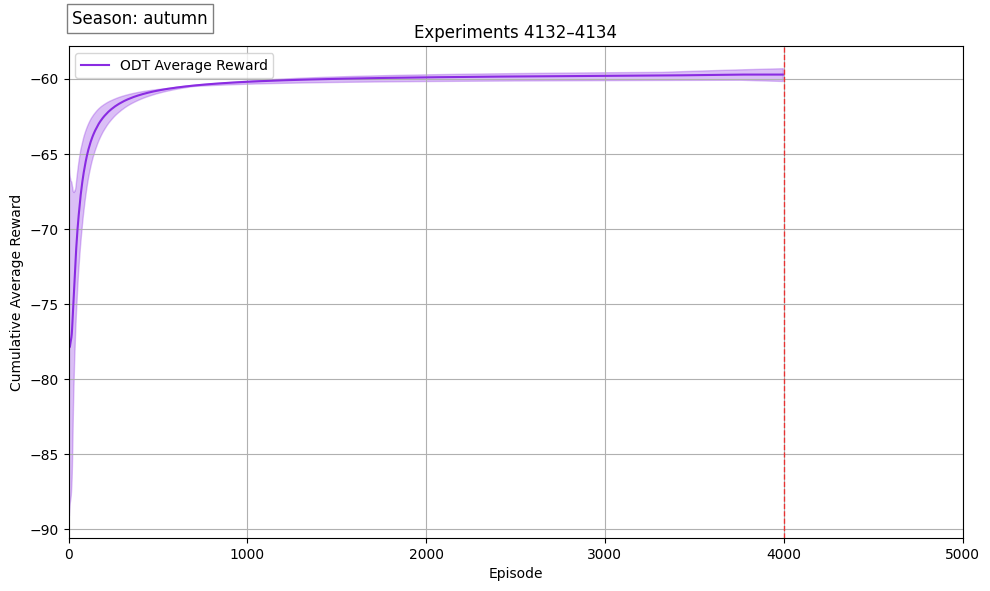

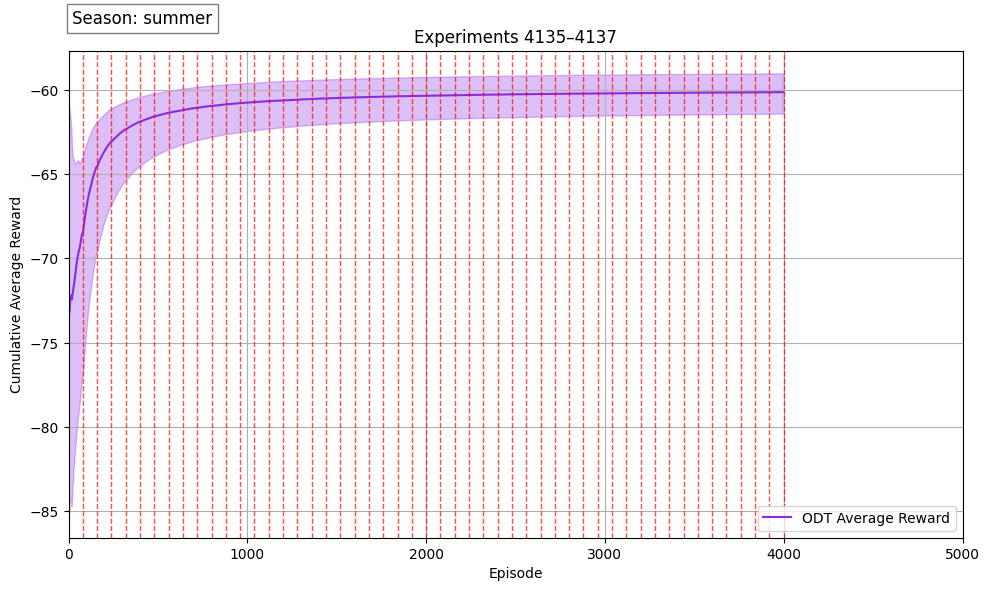

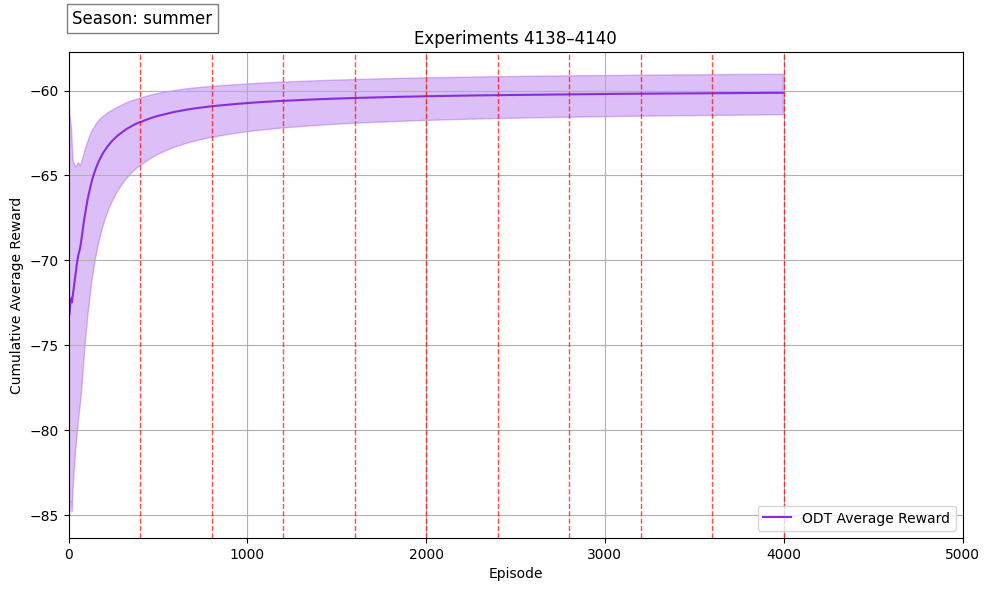

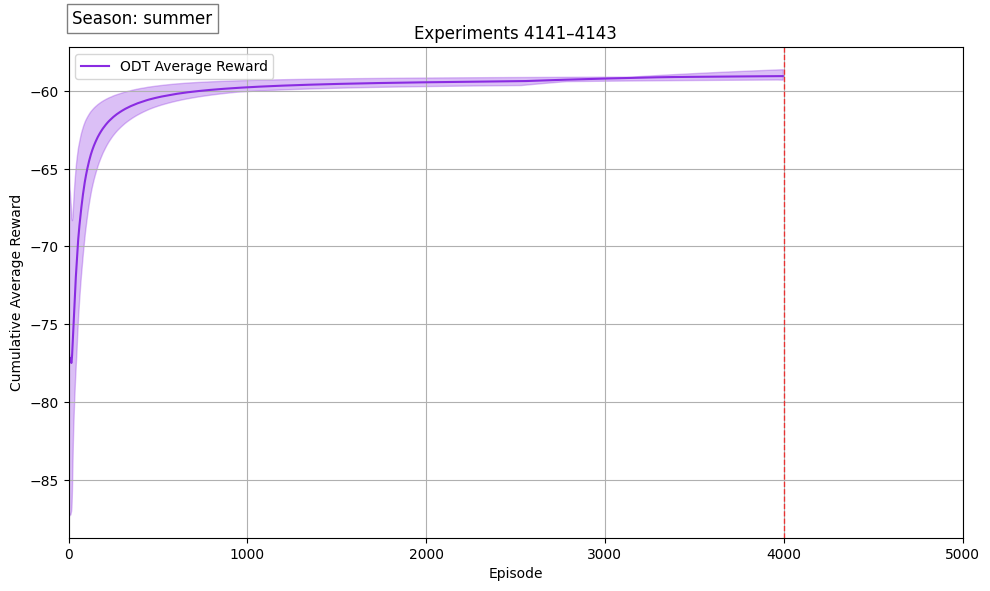

/tmp/ipykernel_80926/372251037.py:62: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


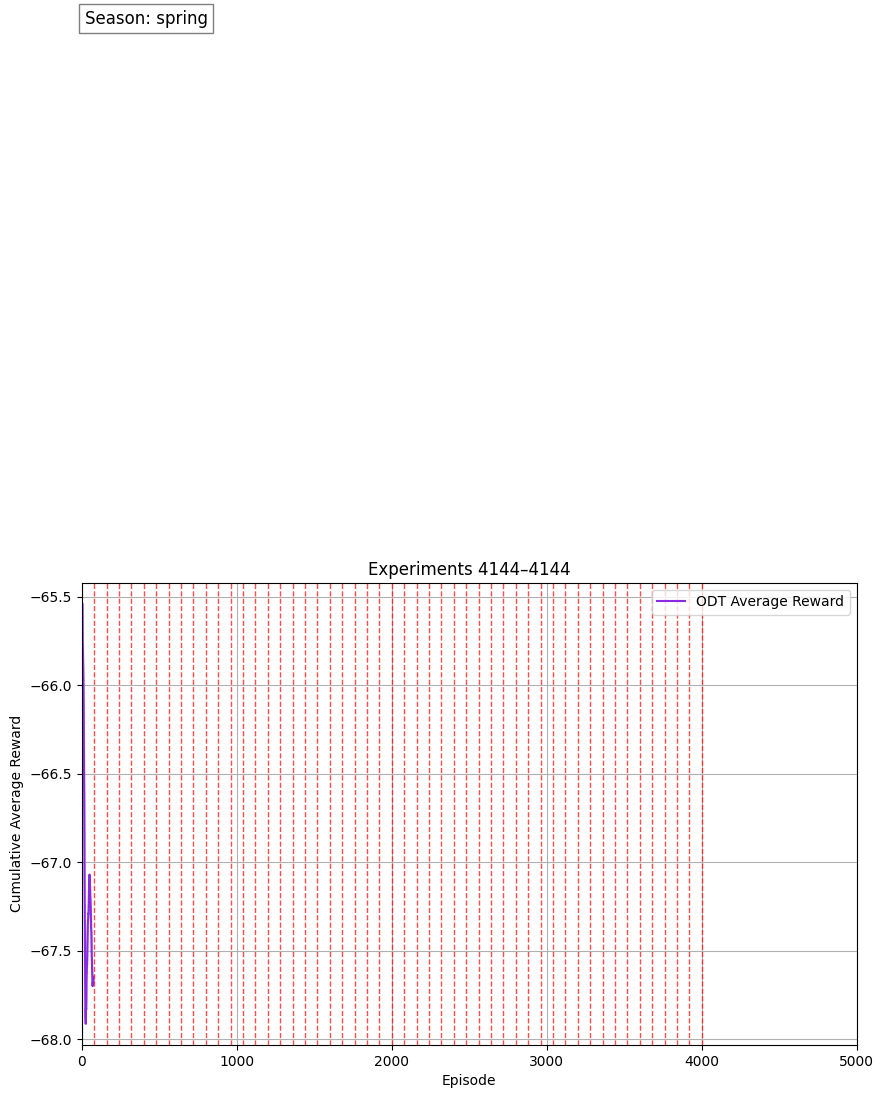

In [7]:
for chunk in experiment_chunks:
    chunk_file = os.path.join(file_path_for_processed_data, f"{chunk[0]}_{chunk[-1]}", f"{chunk[0]}_{chunk[-1]}.csv")
    if not os.path.exists(chunk_file):
        print(f"Missing file for chunk {chunk[0]}–{chunk[-1]}; skipping plot.")
        continue

    df = pd.read_csv(chunk_file)

    # Check for mixed seasons (fall back to 'Mixed' if more than one unique value)
    unique_seasons = df['season'].unique()
    season_label = unique_seasons[0] if len(unique_seasons) == 1 else "Mixed"

    agg_data = (
        df
        .groupby(['episode', 'algorithm'])['cumulative_reward']
        .agg(['mean', 'min', 'max'])
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(10, 6))

    for algo in agg_data['algorithm'].unique():
        algo_data = agg_data[agg_data['algorithm'] == algo]
        ax.fill_between(
            algo_data['episode'],
            algo_data['min'],
            algo_data['max'],
            color=colors.get(algo, 'gray'),
            alpha=0.3
        )
        ax.plot(
            algo_data['episode'],
            algo_data['mean'],
            color=colors.get(algo, 'gray'),
            label=f'{algo} Average Reward'
        )

    # Estimate eps_per_agg if needed
    if 'eps_per_agg' in df.columns:
        eps_per_agg = df['eps_per_agg'].iloc[0]
    else:
        num_aggs = df['num_aggs'].iloc[0]
        max_episode = df['episode'].max()
        eps_per_agg = int(np.ceil(max_episode / num_aggs))

    num_aggs = df['num_aggs'].iloc[0]
    for agg in range(1, int(num_aggs) + 1):
        ax.axvline(x=agg * eps_per_agg, color='r', linestyle='--', linewidth=1, alpha=0.7)

    # Add season label in top-left corner
    x_pos = df['episode'].min()
    y_pos = df['cumulative_reward'].max() * 0.95
    ax.text(x_pos + 20, y_pos, f"Season: {season_label}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Average Reward')
    ax.set_title(f'Experiments {chunk[0]}–{chunk[-1]}')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, 5000)

    plt.tight_layout()
    plt.show()


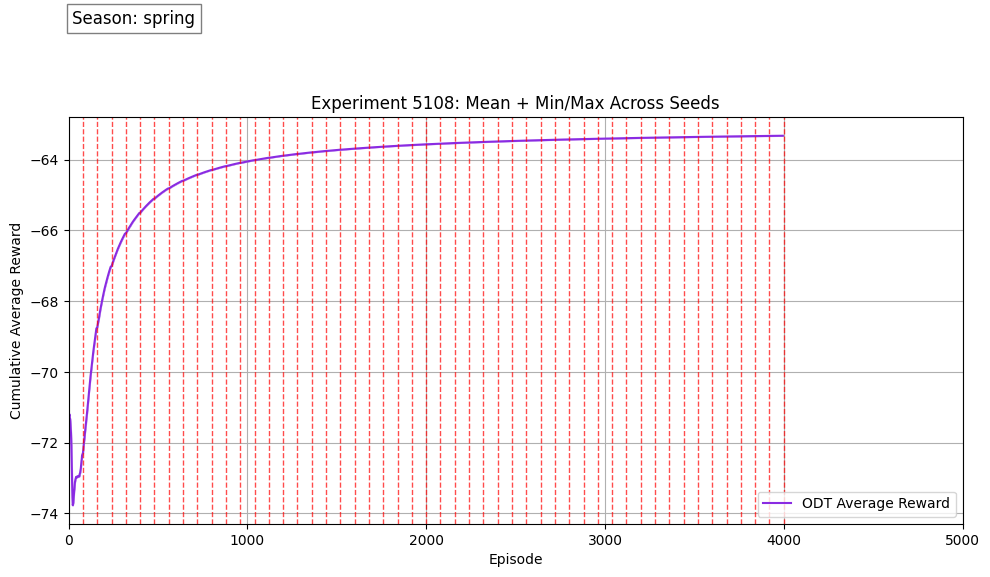

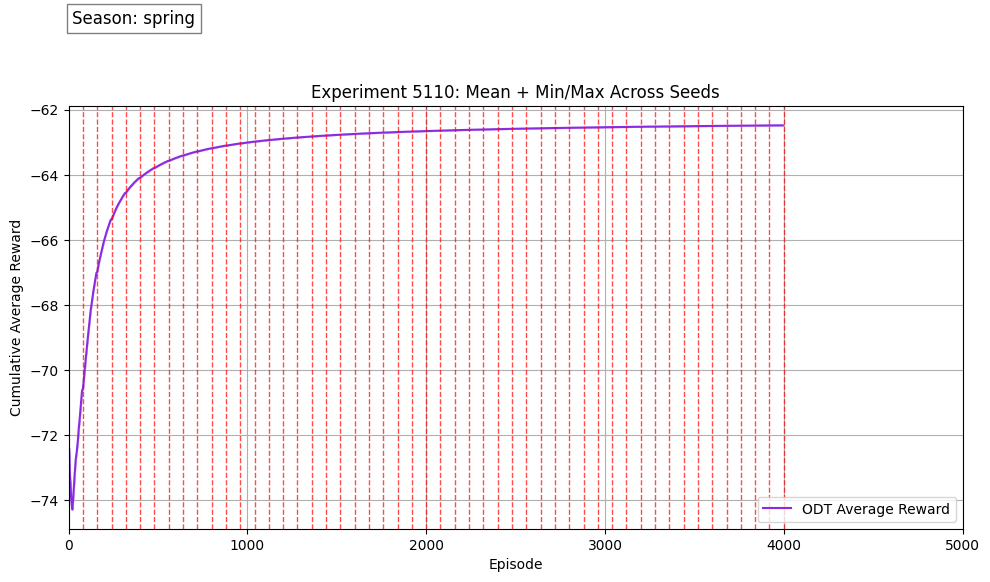

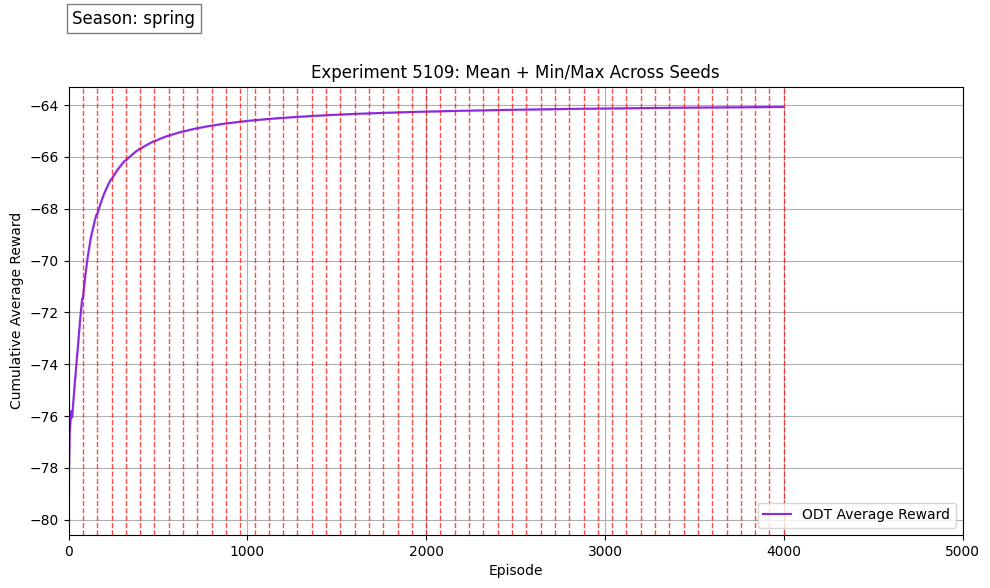

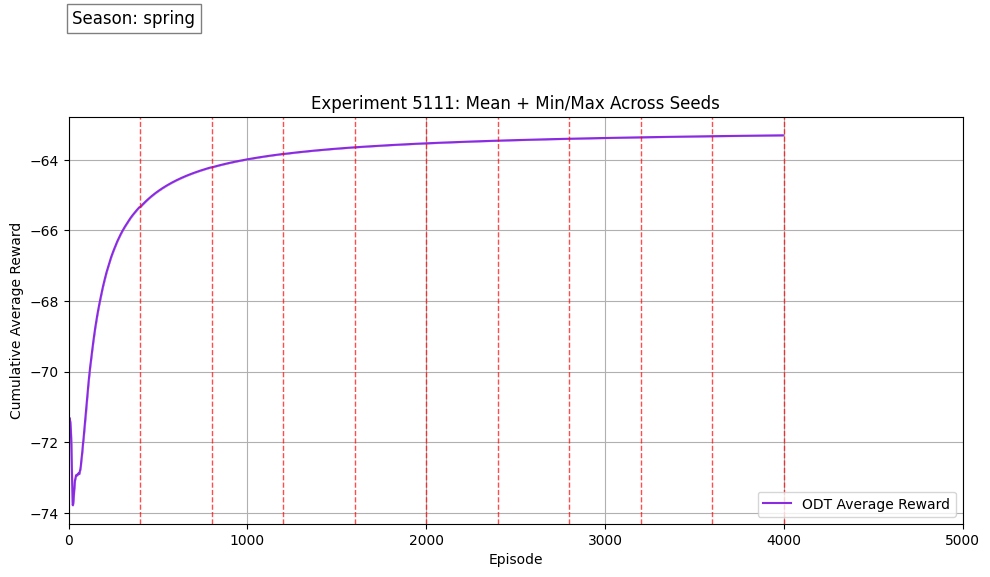

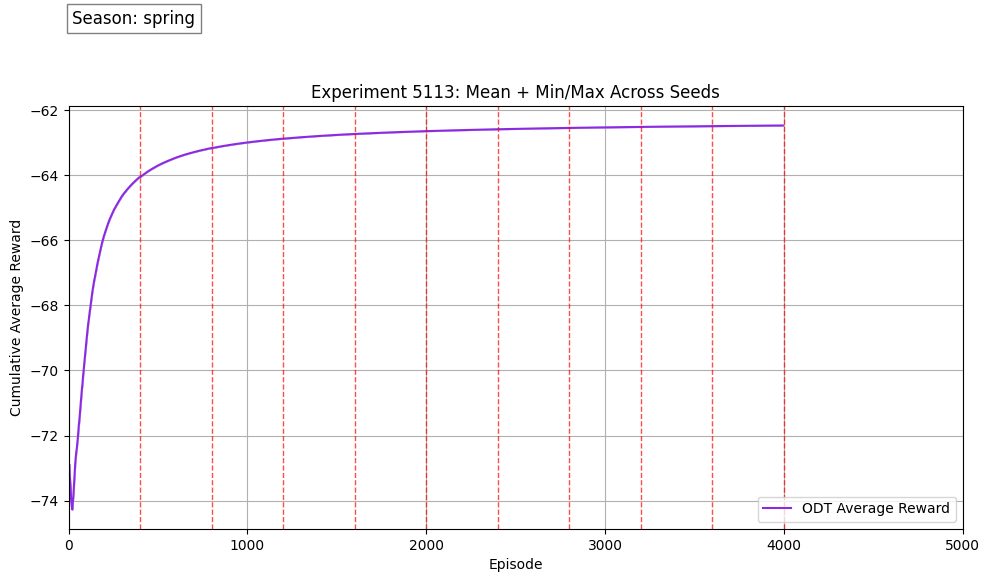

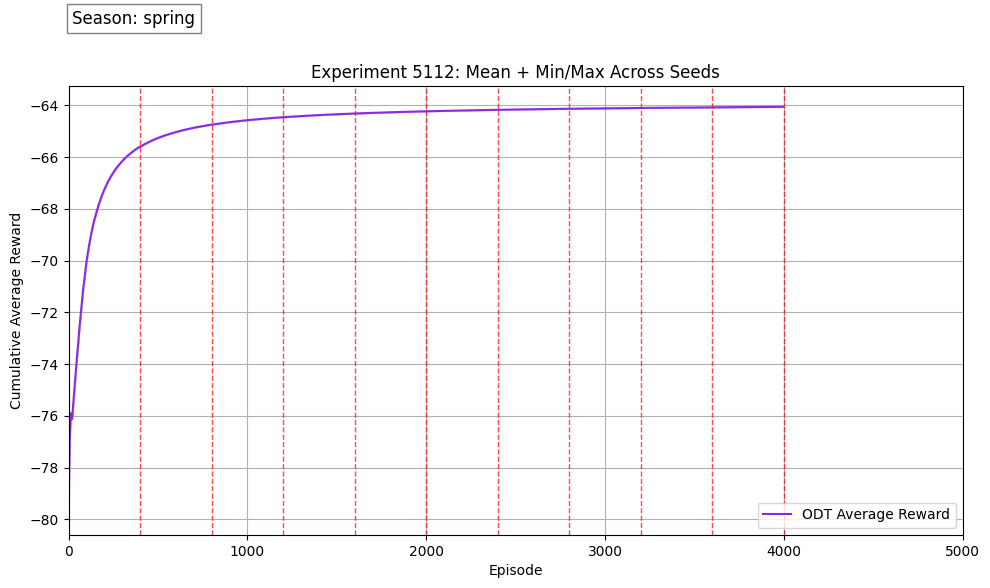

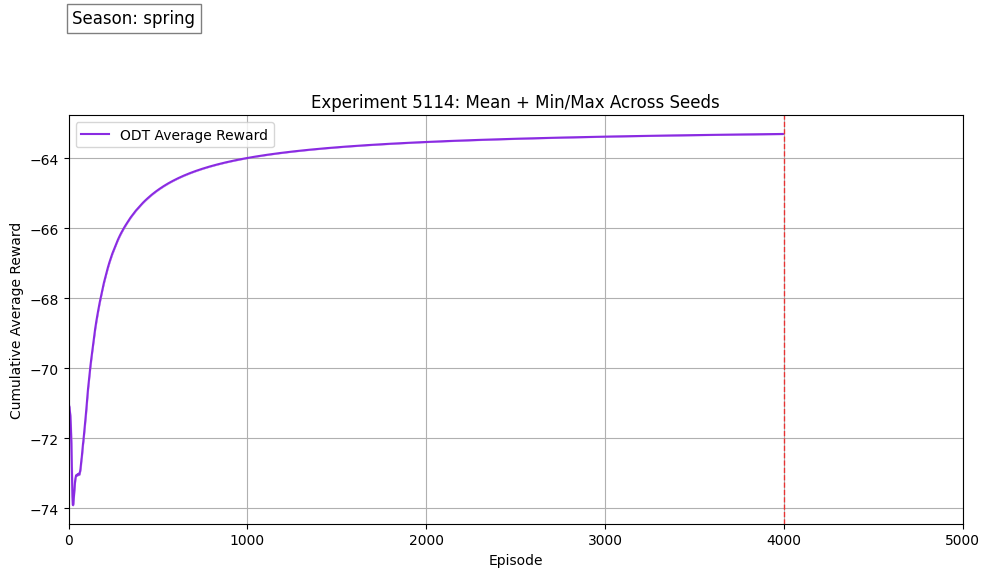

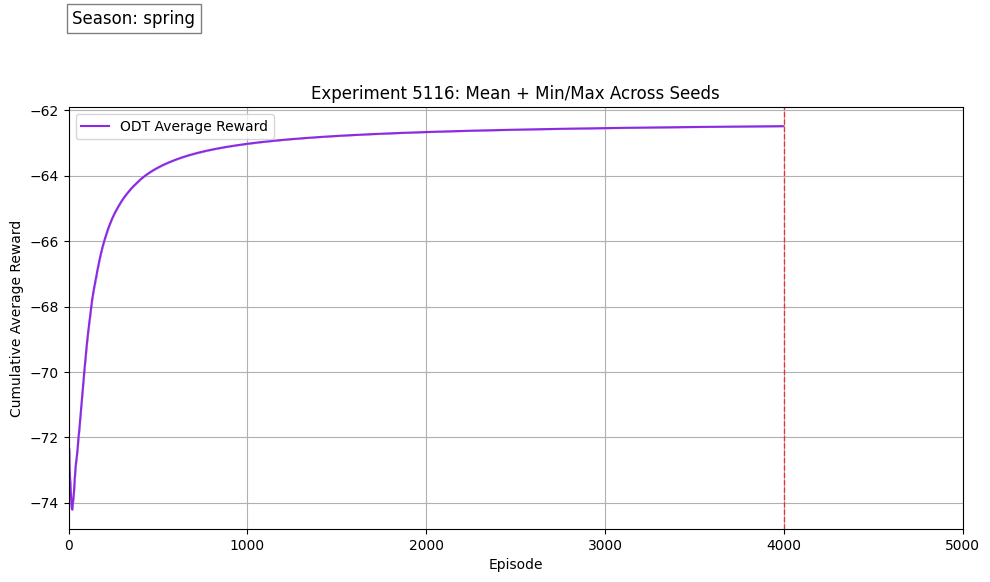

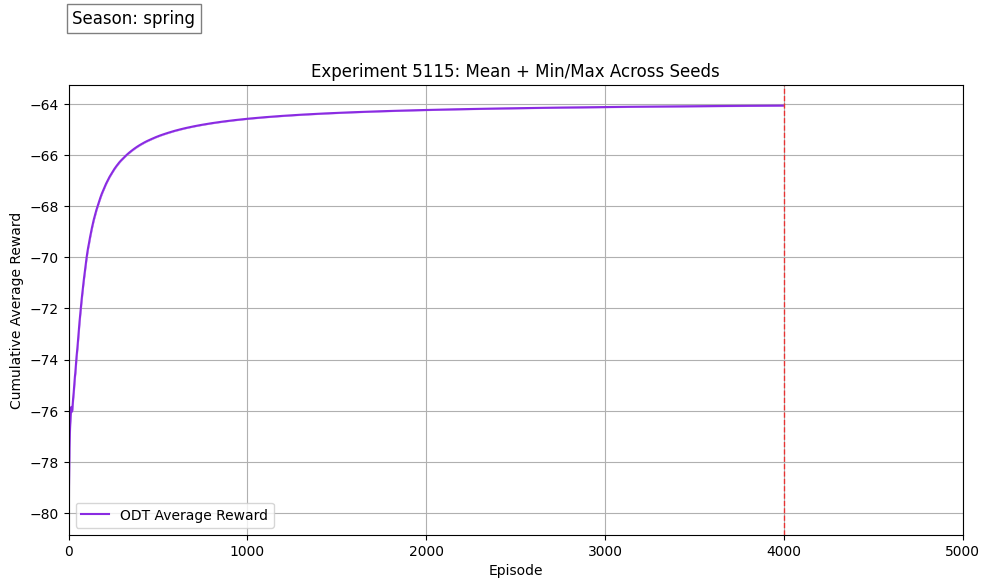

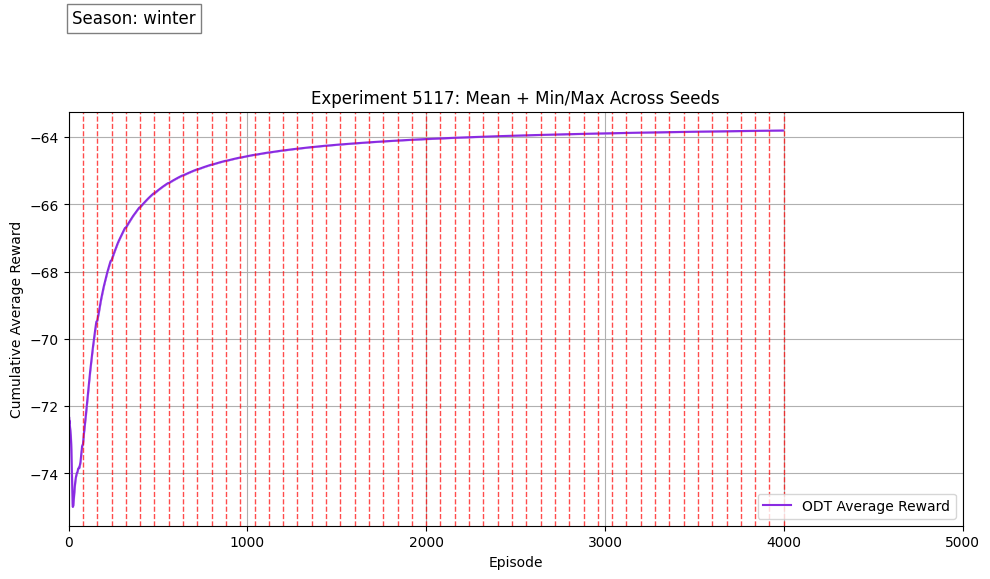

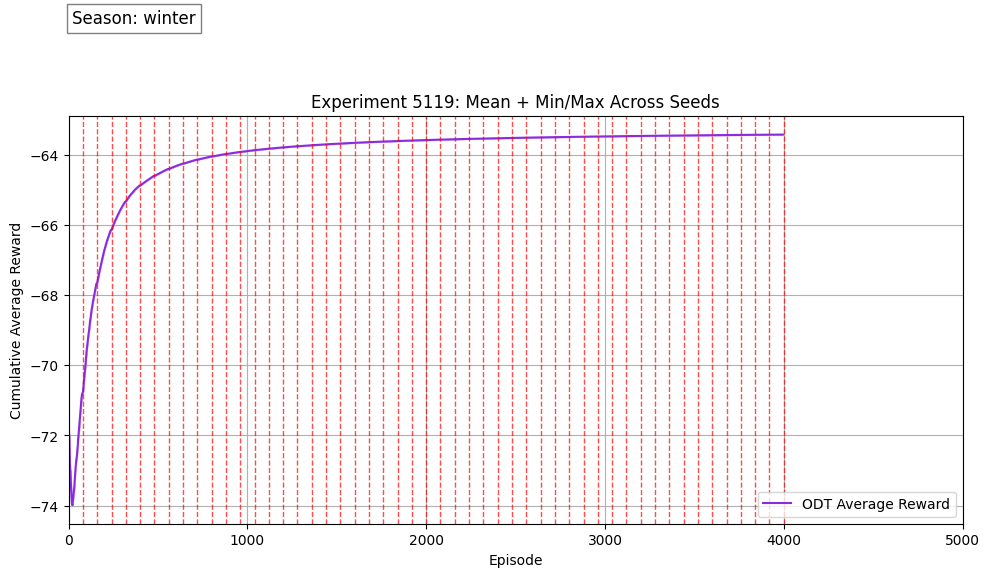

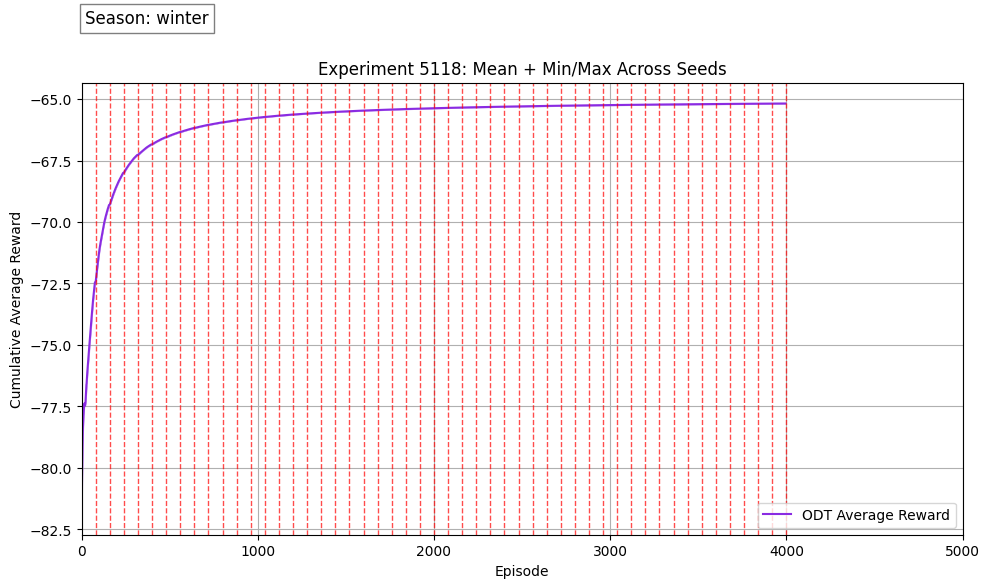

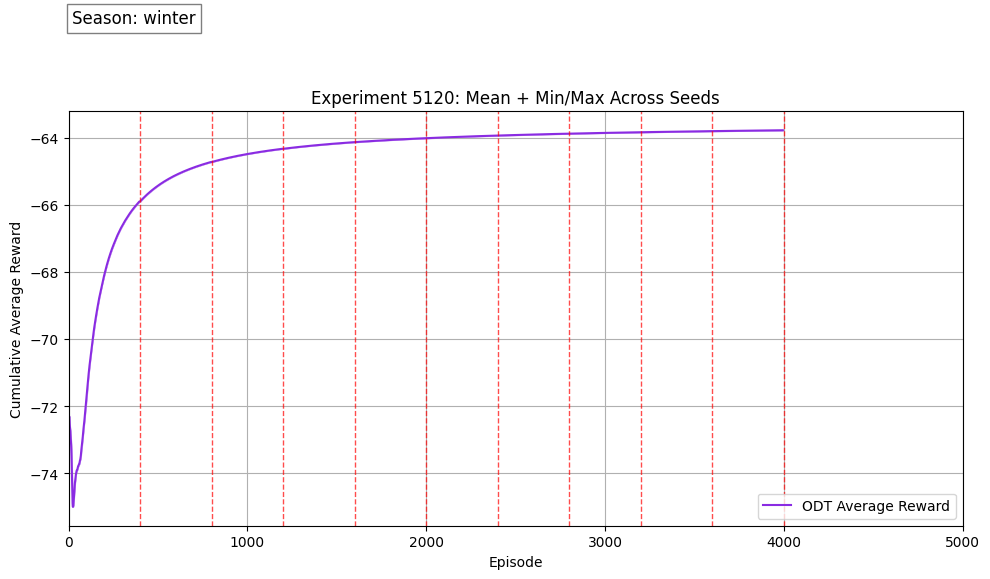

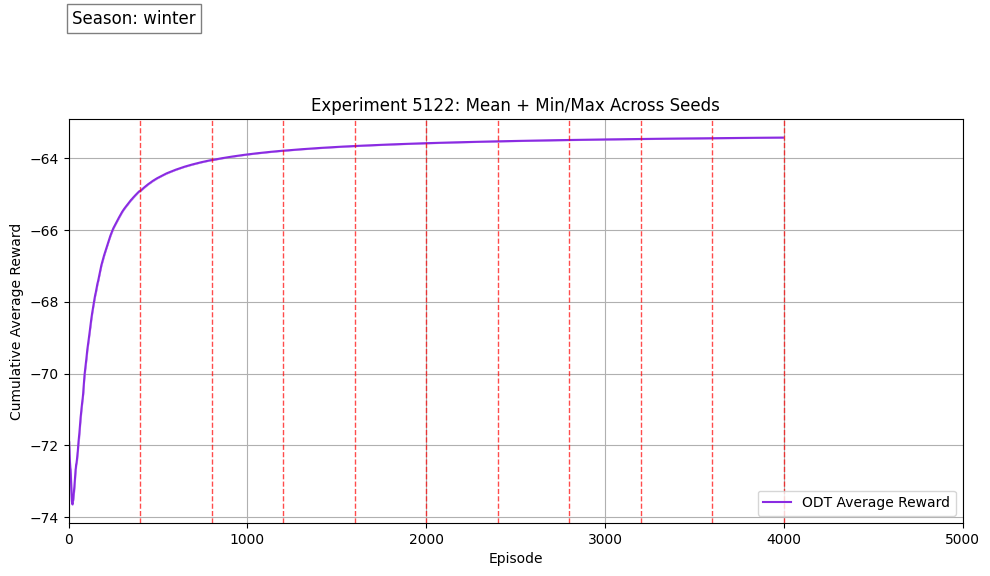

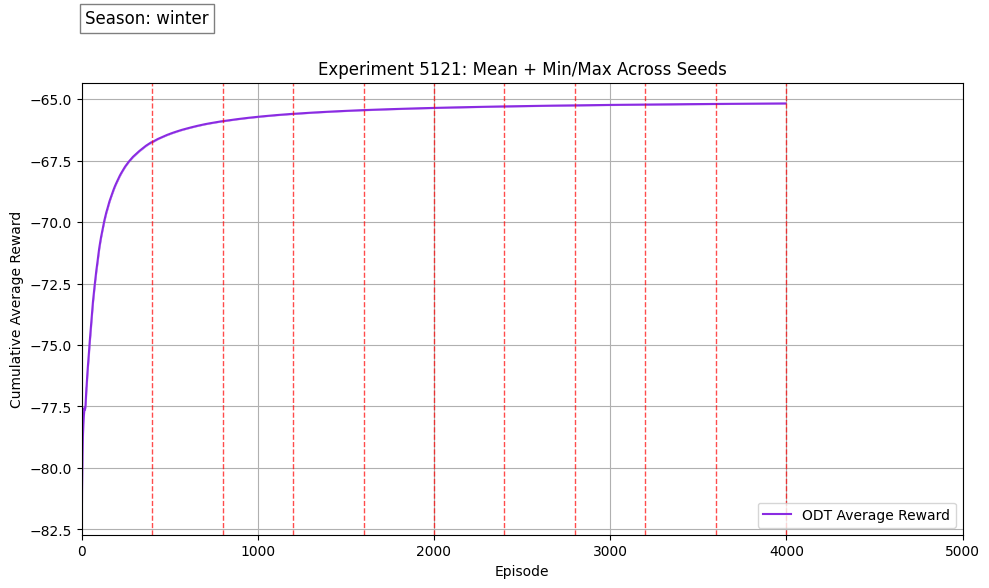

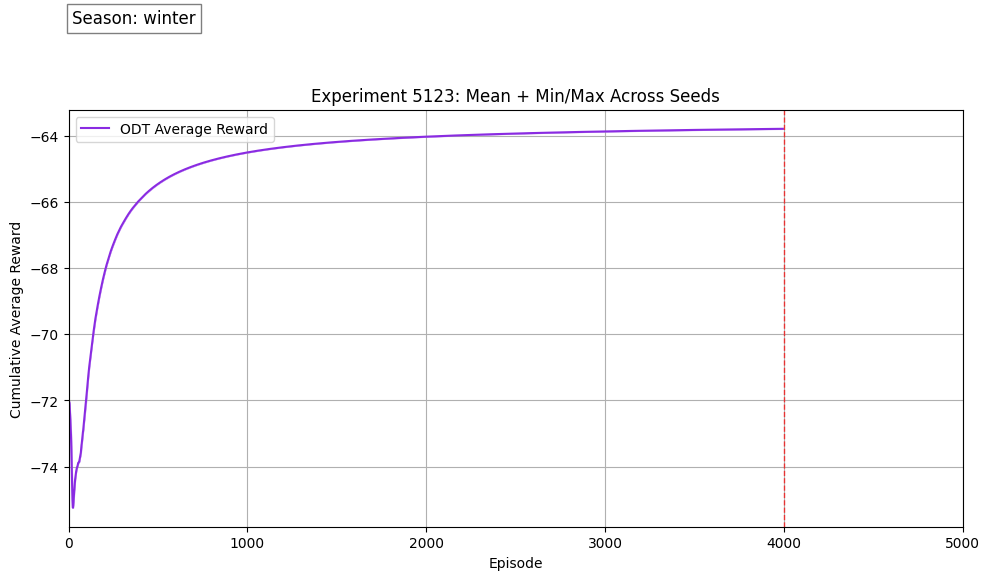

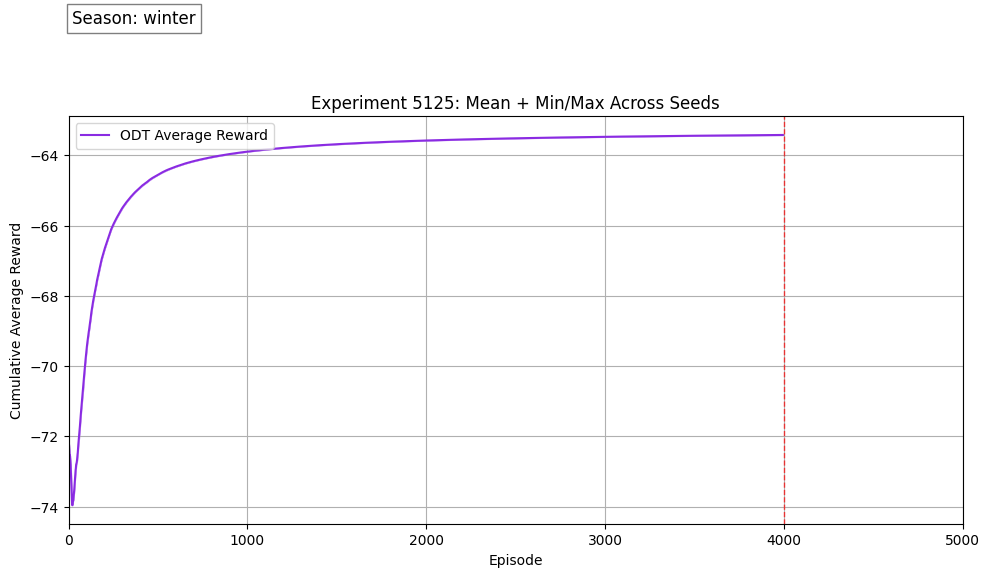

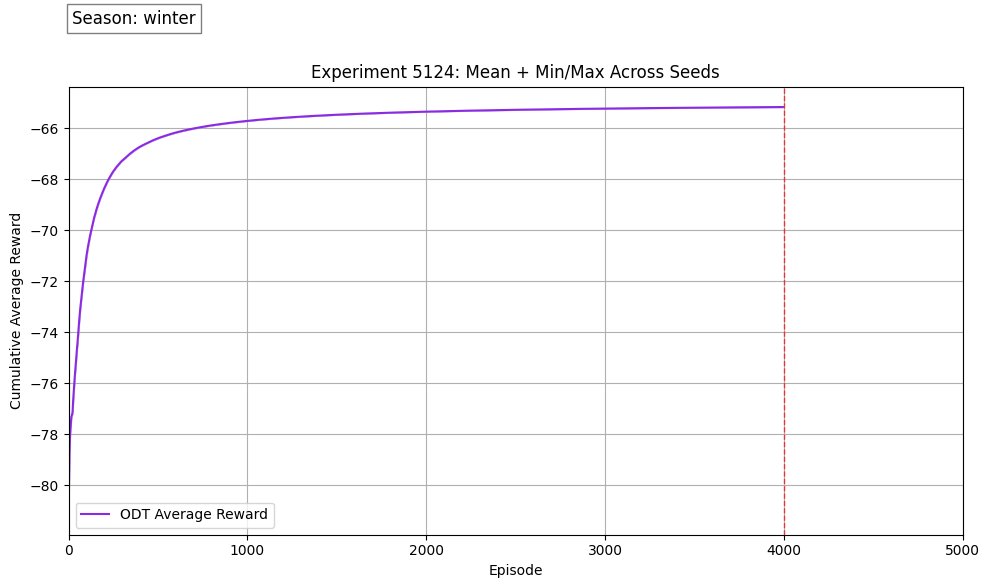

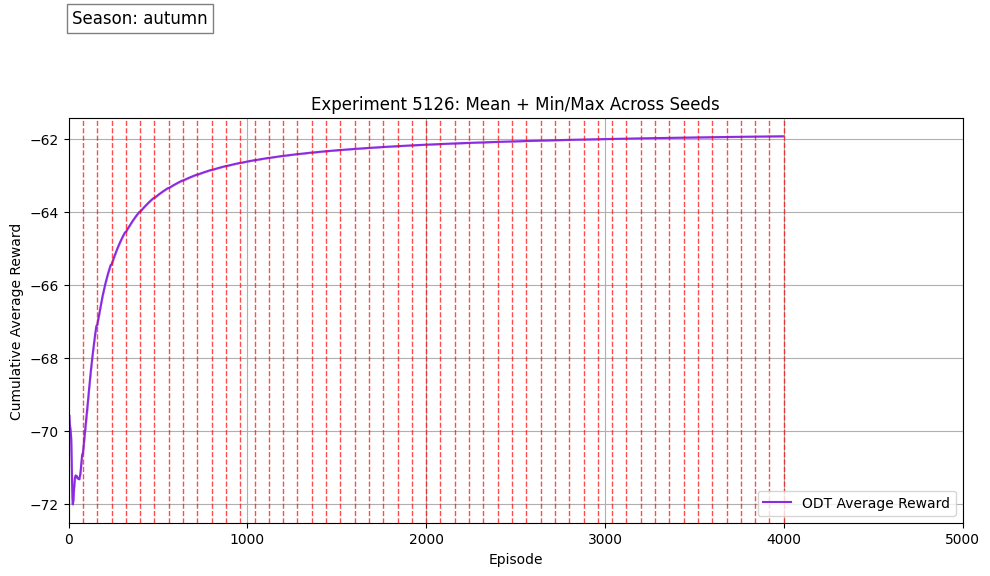

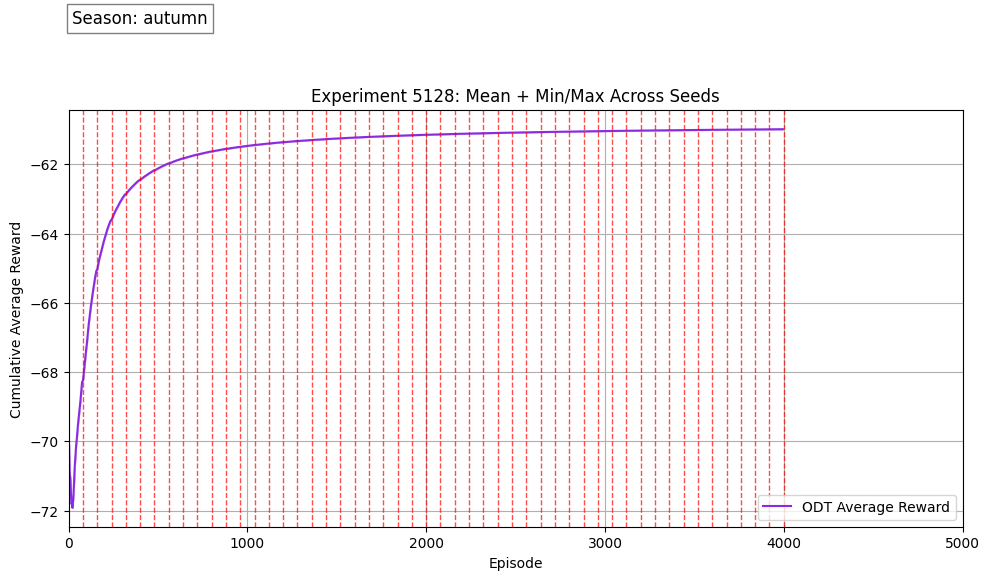

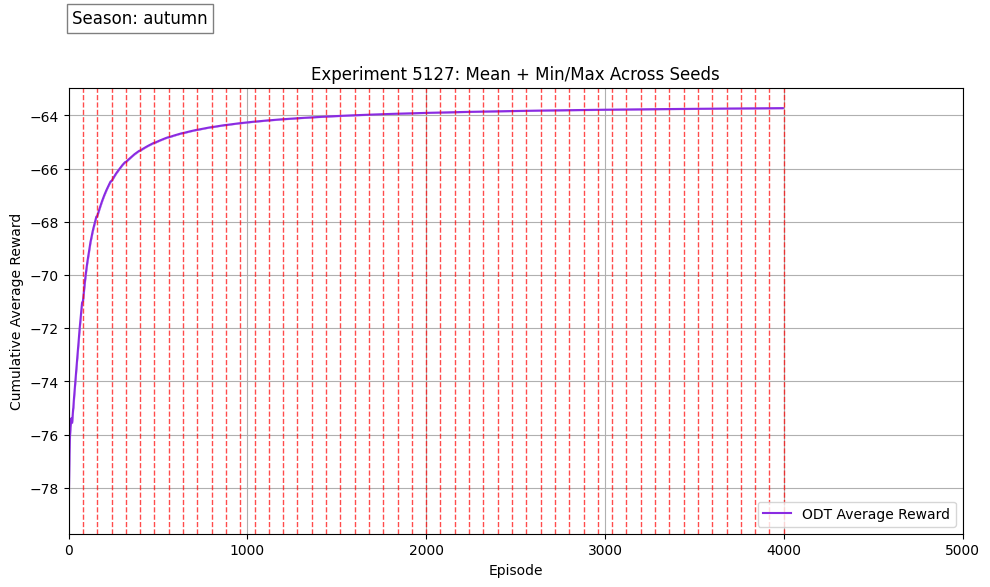

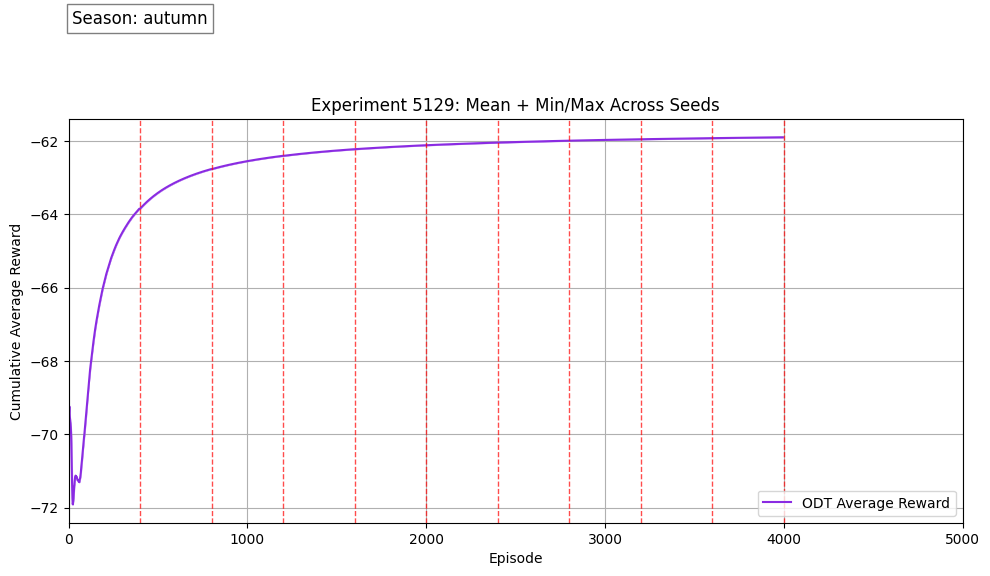

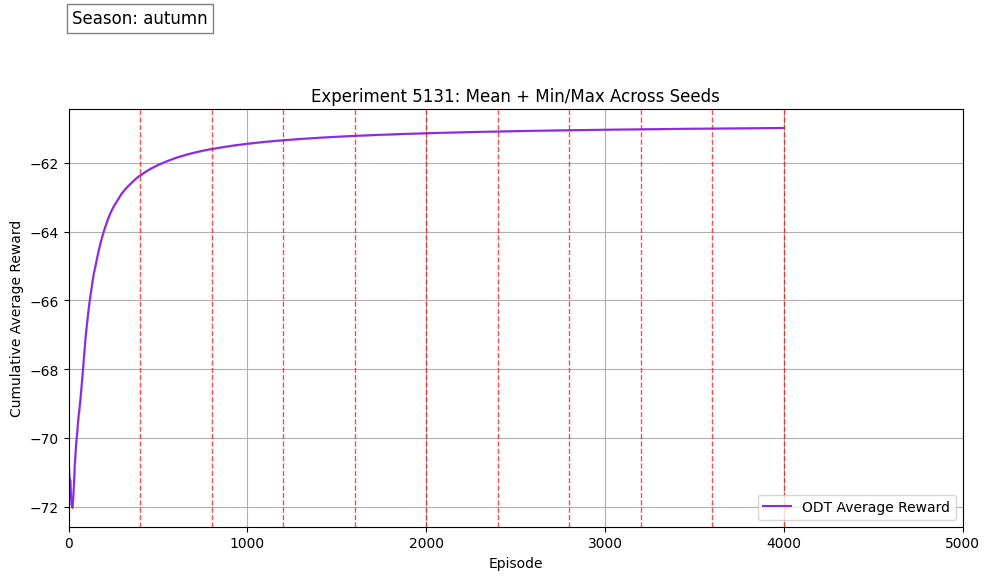

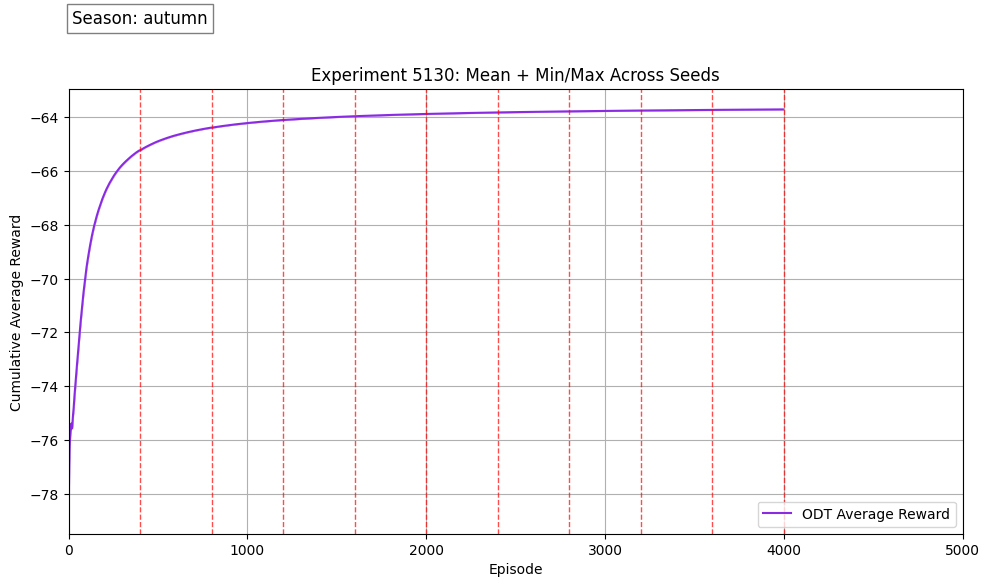

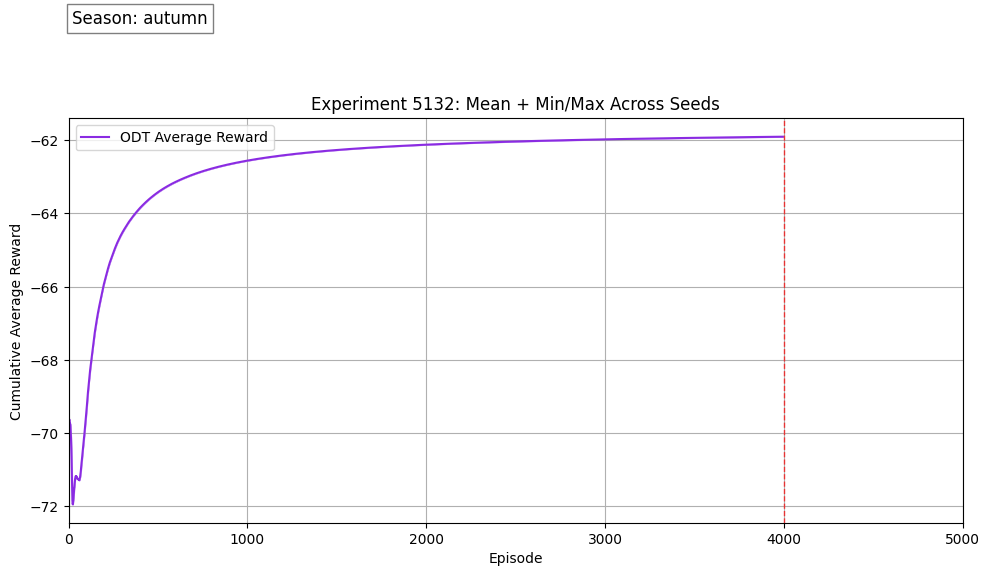

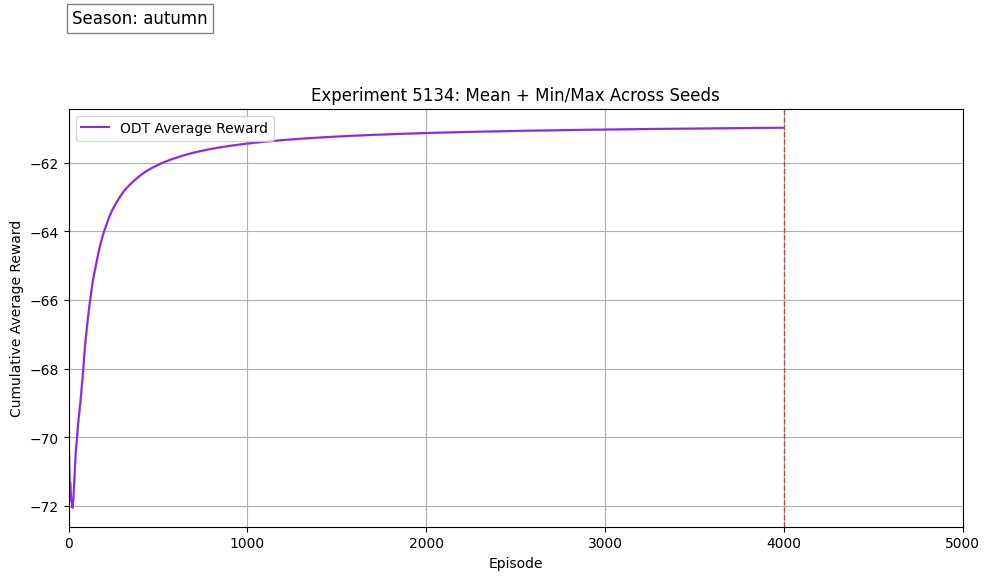

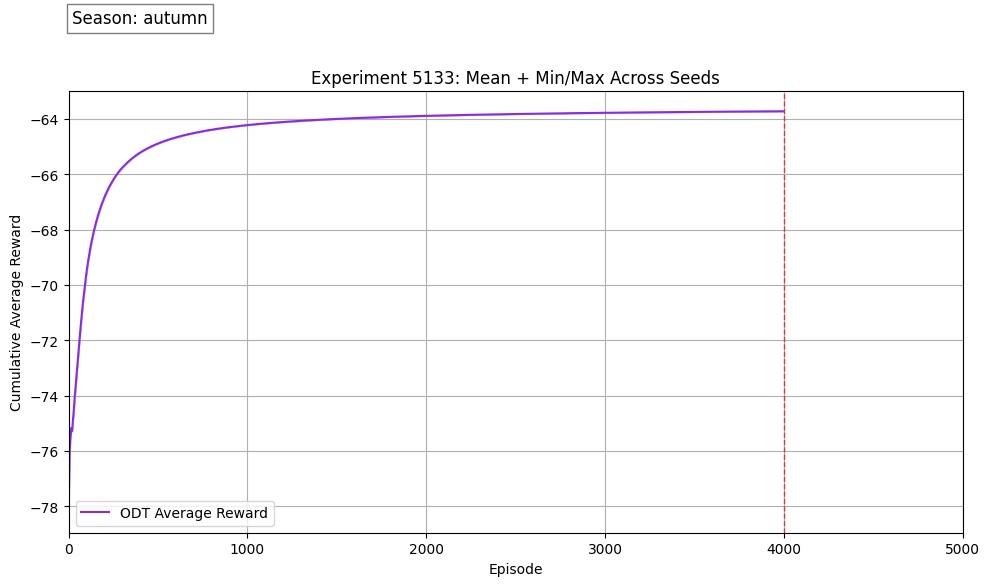

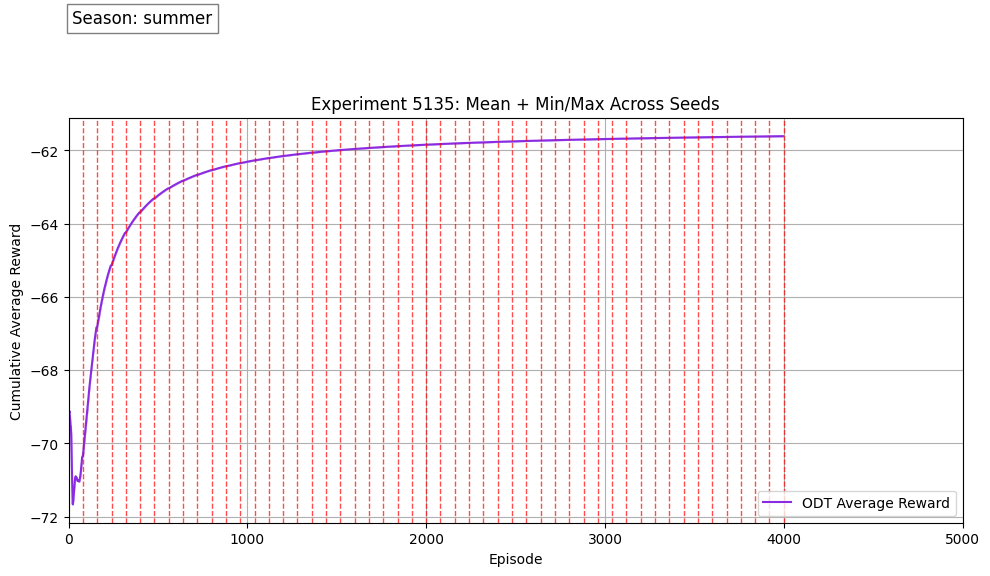

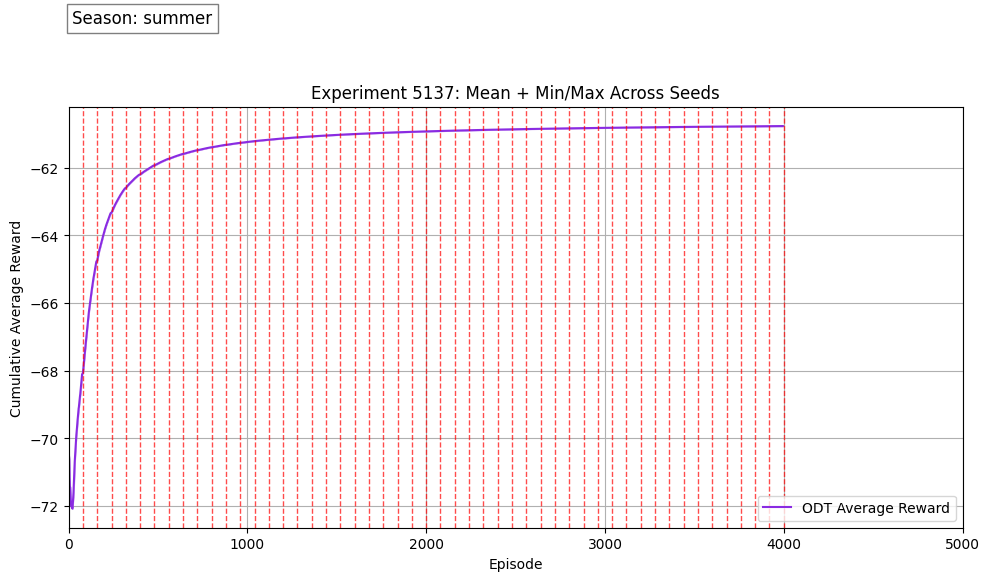

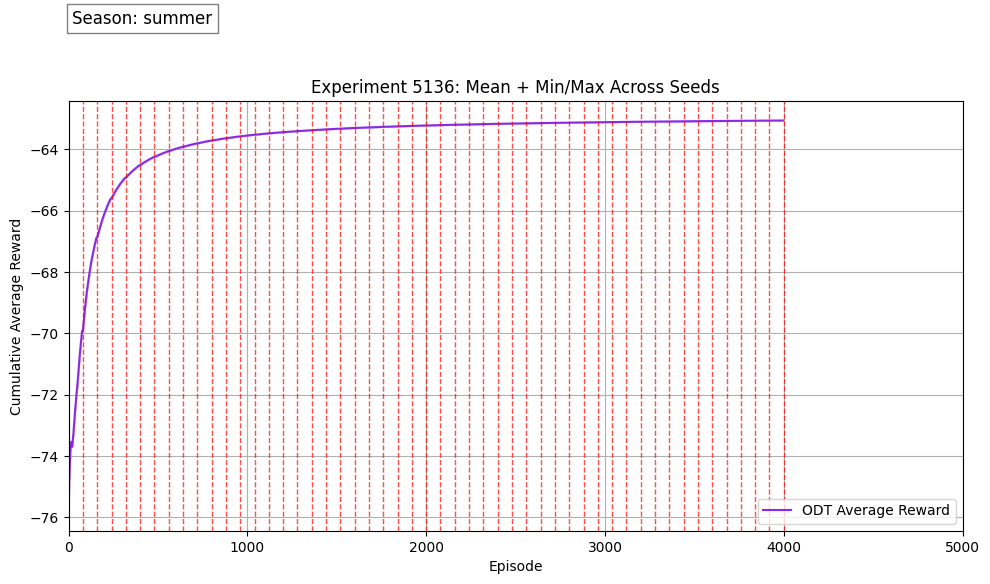

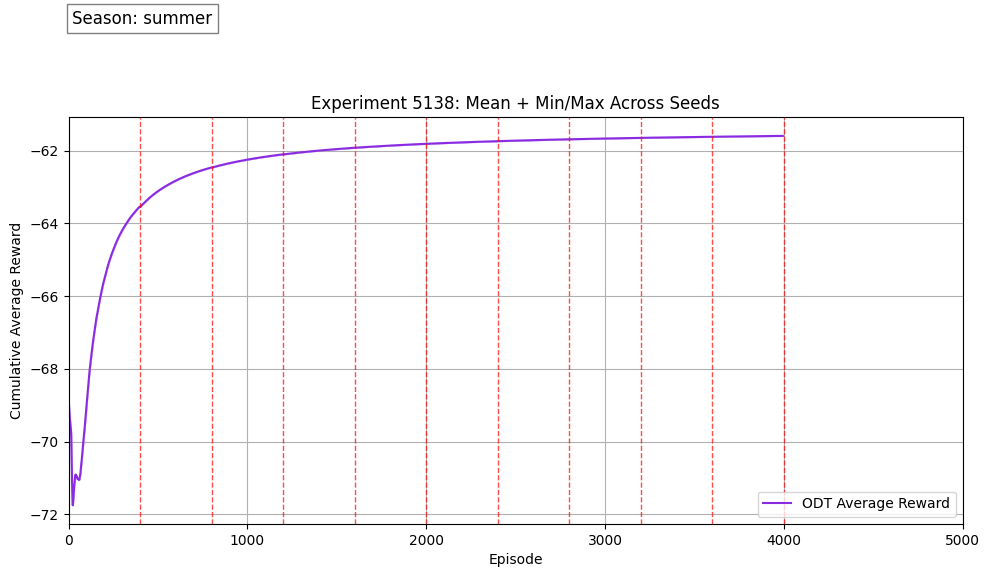

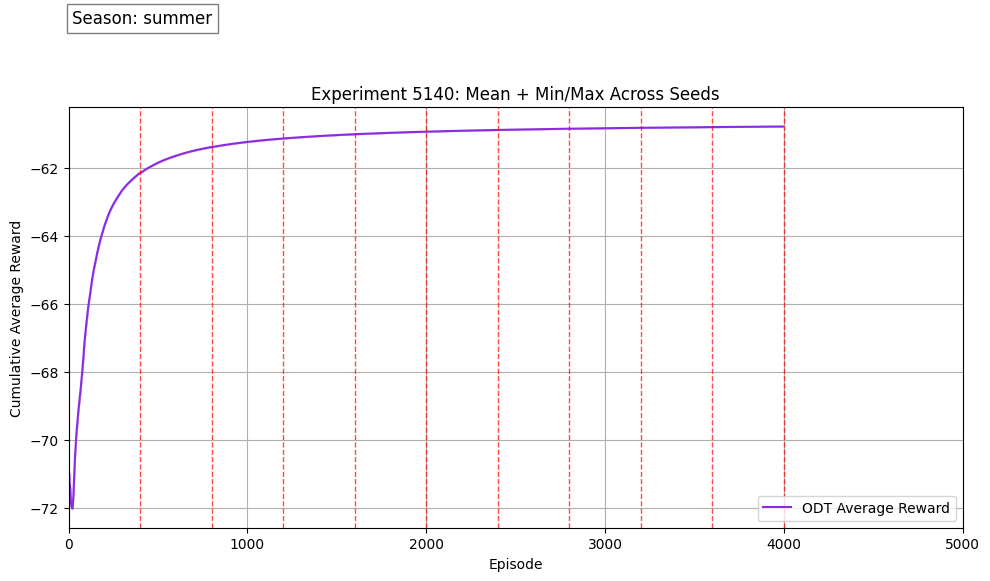

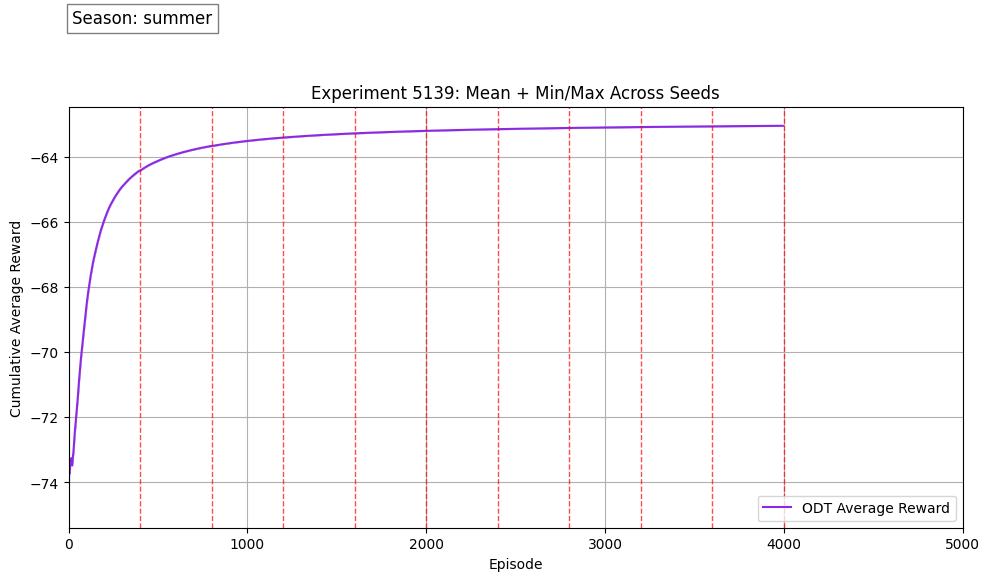

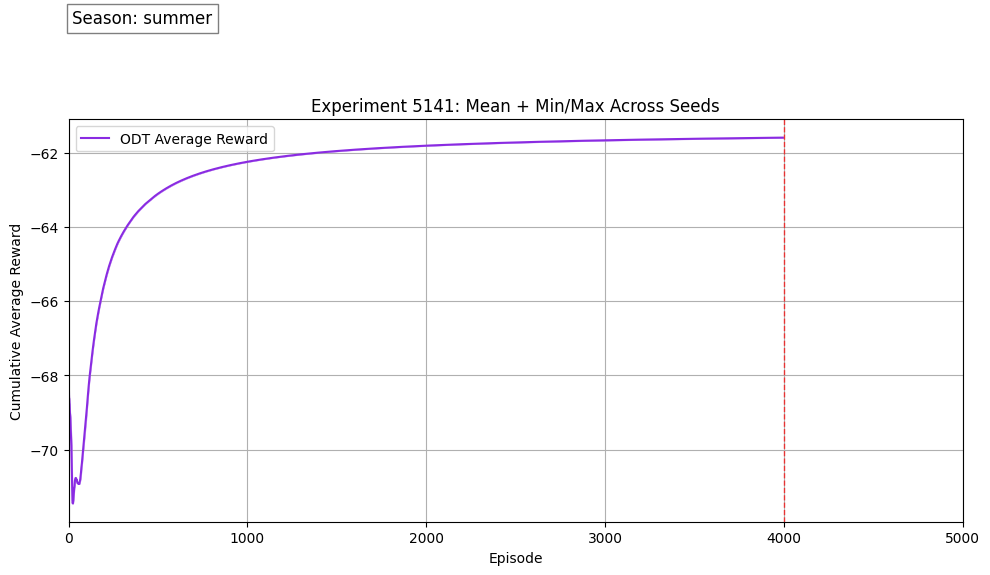

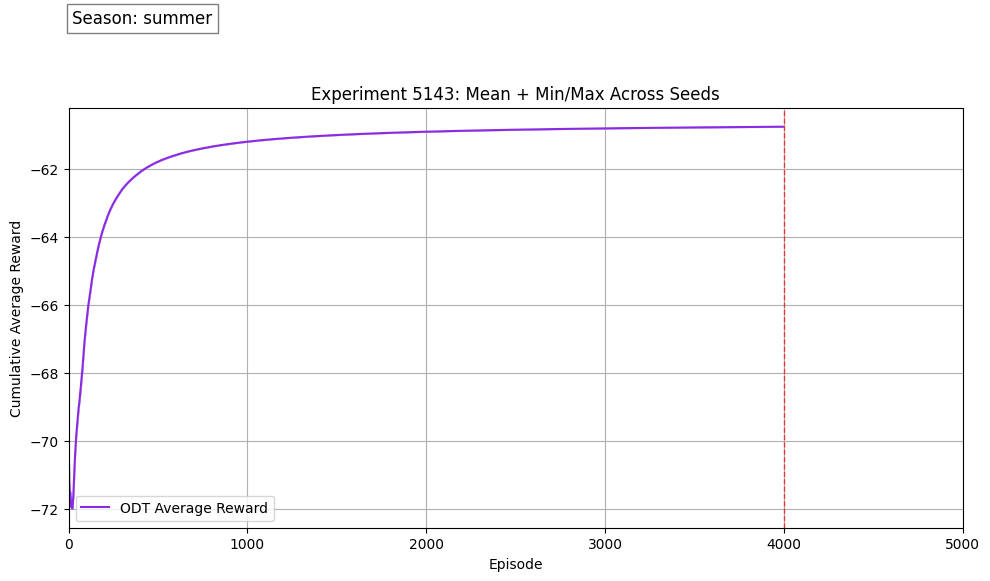

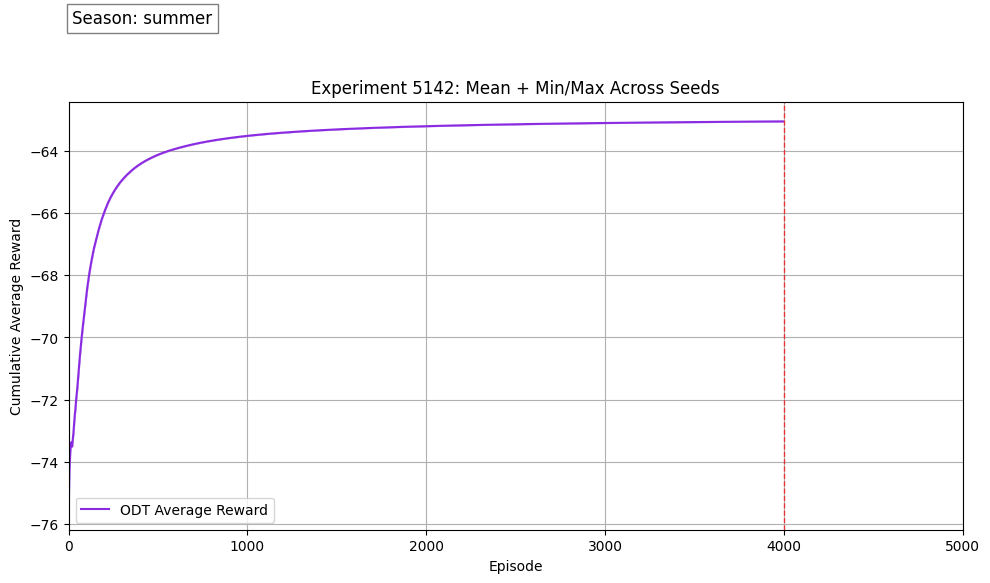

Missing file for chunk 5144–5144; skipping.


In [10]:
for chunk in experiment_chunks:
    chunk_file = os.path.join(file_path_for_processed_data, f"{chunk[0]}_{chunk[-1]}", f"{chunk[0]}_{chunk[-1]}.csv")
    if not os.path.exists(chunk_file):
        print(f"Missing file for chunk {chunk[0]}–{chunk[-1]}; skipping.")
        continue

    df_chunk = pd.read_csv(chunk_file)

    for exp_num in df_chunk['exp_num'].unique():
        df = df_chunk[df_chunk['exp_num'] == exp_num]
        unique_seasons = df['season'].unique()
        season_label = unique_seasons[0] if len(unique_seasons) == 1 else "Mixed"

        agg_data = (
            df
            .groupby(['episode', 'algorithm'])['cumulative_reward']
            .agg(['mean', 'min', 'max'])
            .reset_index()
        )

        fig, ax = plt.subplots(figsize=(10, 6))

        for algo in agg_data['algorithm'].unique():
            algo_data = agg_data[agg_data['algorithm'] == algo]
            ax.fill_between(algo_data['episode'], algo_data['min'], algo_data['max'], color=colors.get(algo, 'gray'), alpha=0.3)
            ax.plot(algo_data['episode'], algo_data['mean'], color=colors.get(algo, 'gray'), label=f'{algo} Average Reward')

        eps_per_agg = df['eps_per_agg'].iloc[0] if 'eps_per_agg' in df.columns else int(np.ceil(df['episode'].max() / df['num_aggs'].iloc[0]))
        for agg in range(1, int(df['num_aggs'].iloc[0]) + 1):
            ax.axvline(x=agg * eps_per_agg, color='r', linestyle='--', linewidth=1, alpha=0.7)

        ax.text(20, df['cumulative_reward'].max() * 0.95, f"Season: {season_label}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
        ax.set_xlabel('Episode')
        ax.set_ylabel('Cumulative Average Reward')
        ax.set_title(f'Experiment {exp_num}: Mean + Min/Max Across Seeds')
        ax.legend()
        ax.grid(True)
        ax.set_xlim(0, 5000)
        plt.tight_layout()
        plt.show()
